#### **Introduction**
These are some miscellaneous data analysis that need more deeper reviews in person, but explored lightly due to timely constraints

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
df = pd.read_parquet('../data/logs.parquet')

#### **1. `PRI *` from request**

`Pri *` request should never be used according to the following websites:
  - https://www.rfc-editor.org/rfc/rfc7540#page-78
  - https://stackoverflow.com/questions/50434269/pri-method-in-http2-implementation-causing-issue,



Although there were only 435 requests from various IP addresses, it may be worth digging into

In [3]:
pri_data = df[df['request'].str.contains('PRI *', na=False)]

print(pri_data)
pri_data.to_csv('../data_preprocess/pri.csv')

               client_ip  user                time  \
479        167.94.138.41  None 2024-11-07 00:00:57   
371188    195.252.220.48  None 2024-11-07 20:43:20   
371205    195.252.220.48  None 2024-11-07 20:43:21   
371404    195.252.220.48  None 2024-11-07 20:43:36   
371817    195.252.220.48  None 2024-11-07 20:44:22   
...                  ...   ...                 ...   
10931518   172.93.132.12  None 2025-01-11 00:30:21   
10931588   172.93.132.12  None 2025-01-11 00:31:33   
10931593   172.93.132.12  None 2025-01-11 00:31:34   
10931665   172.93.132.12  None 2025-01-11 00:32:33   
10931675   172.93.132.12  None 2025-01-11 00:32:34   

                                                    request  http_status  \
479                                          PRI * HTTP/2.0          400   
371188    GET /courses/CS25100/exams/SPRING-2022-2/acb73...          200   
371205    GET /courses/CS25100/exams/SPRING-2022-2 HTTP/2.0          200   
371404    GET /courses/CS25100/exams/SPRING-202

In [4]:
# Count the number of requests per IP address
ip_request_counts = pri_data['client_ip'].value_counts()

# Create a table of request counts per IP address
ip_request_table = ip_request_counts.reset_index()
ip_request_table.columns = ['client_ip', 'request_count']

# Display the table
ip_request_table.head(20)



,client_ip,request_count
0,192.69.182.54,120
1,172.226.87.84,65
2,172.93.132.12,21
3,69.174.143.75,20
4,47.227.207.162,16
5,195.252.206.149,15
6,128.210.106.75,10
7,195.252.220.48,10
8,128.211.252.245,8
9,146.75.136.1,6


#### 2. `GET .env` from requests
Requests for .env files are highly suspicious, as these files typically contain sensitive configuration data

Total 4,579 requests targeting .env files were detected.
  - Mostly from the following IP address:
    - 193.41.206.24: 1,683 requests (36.7% of total).
    - 193.41.206.36: 785 requests.
    - 209.97.165.151: 266 requests.

In [8]:
import re
env_data = df[df['request'].str.contains(r'\.env', na=False, regex=True)]

print(env_data)
env_data.to_csv('../data_preprocess/env.csv')

                client_ip  user                time  \
123277     185.82.219.179  None 2024-11-07 04:57:25   
131612     87.120.116.117  None 2024-11-07 05:28:33   
134407     179.43.168.146  None 2024-11-07 05:41:46   
134427     179.43.168.146  None 2024-11-07 05:41:49   
134429     179.43.168.146  None 2024-11-07 05:41:50   
...                   ...   ...                 ...   
10927135    193.41.206.36  None 2025-01-10 23:24:36   
10927136    193.41.206.36  None 2025-01-10 23:24:38   
10927137    193.41.206.36  None 2025-01-10 23:24:39   
10930802  146.190.117.235  None 2025-01-11 00:25:15   
10930803  146.190.117.235  None 2025-01-11 00:25:15   

                                 request  http_status  request_body_bytes  \
123277                GET /.env HTTP/1.0          302                 154   
131612                GET /.env HTTP/1.1          302                  29   
134407         GET /.env.backup HTTP/1.1          302                  29   
134427           GET /.env.live

In [9]:
# Filter requests that target .env files
env_requests = env_data[env_data['request'].str.contains(r'\.env', na=False, case=False)]

# Summary of the suspicious requests
suspicious_summary = {
    "Total Requests": len(env_requests),
    "Unique IPs": env_requests['client_ip'].nunique(),
    "HTTP Status Distribution": env_requests['http_status'].value_counts().to_dict(),
    "Unique User Agents": env_requests['user_agent'].nunique()
}

# Top IPs making suspicious requests
top_ips = env_requests['client_ip'].value_counts().head(10)

# Displaying the results
suspicious_summary, top_ips


({'Total Requests': 4579,
  'Unique IPs': 213,
  'HTTP Status Distribution': {302: 2345,
   301: 1044,
   502: 513,
   400: 404,
   200: 207,
   404: 56,
   401: 7,
   206: 2,
   403: 1},
  'Unique User Agents': 1196},
 client_ip
 193.41.206.24     1683
 193.41.206.36      785
 209.97.165.151     266
 78.153.140.179     218
 78.153.140.151     183
 78.153.140.224     181
 179.43.168.146     162
 78.153.140.223     152
 78.153.140.177     110
 78.153.140.218      58
 Name: count, dtype: int64)

In [10]:
# Analyze the most common user-agents
top_user_agents = env_requests['user_agent'].value_counts().head(10)
top_user_agents


user_agent
Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.4044.129 Safari/537.36                                                                      362
l9explore/1.2.2                                                                                                                                                                162
Mozilla/5.0 Keydrop                                                                                                                                                            124
Go-http-client/1.1                                                                                                                                                              87
Mozilla/5.0 (Macintosh; Intel Mac OS X 10.15; rv:77.0) Gecko/20100101 Firefox/77.0                                                                                              53
Mozilla/5.0 (Linux; U; Android 4.4.2; en-US; HM NOTE 1W Build/KOT49H) AppleWebKit/534.30 (KHTM

#### **3. HTTP request from Censys**
- scientific community to study Internet. 
- We can opt out from their data collection process by configuring firewall
- https://support.censys.io/hc/en-us/articles/360043177092-Opt-Out-of-Data-Collection
- Total 583 requests

In [5]:
censys_data = df[df['user_agent'].str.contains('censys', na=False)]

print(censys_data)
censys_data.to_csv('../data_preprocess/censys.csv')

                client_ip  user                time  \
455         167.94.138.41  None 2024-11-07 00:00:56   
153828     167.94.145.107  None 2024-11-07 08:40:55   
153833     167.94.145.107  None 2024-11-07 08:41:06   
153834     167.94.145.107  None 2024-11-07 08:41:07   
153835     167.94.145.107  None 2024-11-07 08:41:07   
...                   ...   ...                 ...   
10917710    199.45.155.67  None 2025-01-10 20:43:26   
10926428  162.142.125.210  None 2025-01-10 23:13:03   
10926433  162.142.125.210  None 2025-01-10 23:13:11   
10926437  162.142.125.210  None 2025-01-10 23:13:19   
10926441  162.142.125.210  None 2025-01-10 23:13:24   

                                                    request  http_status  \
455                                          GET / HTTP/1.1          502   
153828                                       GET / HTTP/1.1          302   
153833                                  GET /login HTTP/1.1          200   
153834                   GET /publi

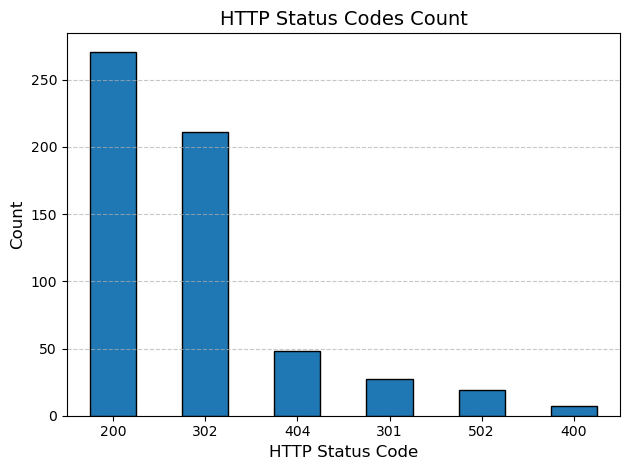

In [6]:
import matplotlib.pyplot as plt

# Count the occurrences of each HTTP status code
http_status_counts = censys_data['http_status'].value_counts()

# Plot the distribution of HTTP status codes
plt.figure()
http_status_counts.plot(kind='bar', edgecolor='black')
plt.title('HTTP Status Codes Count', fontsize=14)
plt.xlabel('HTTP Status Code', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
